Настя Панасюк

In [ ]:
!gdown https://drive.google.com/uc?id=1L6ivCo7-18i_fu8bGy091MHEqMS2hMXY
!gdown https://drive.google.com/uc?id=15gosW2-sW7Gc5s5cBKWPbXypJxJMiOud

Downloading...
From: https://drive.google.com/uc?id=1L6ivCo7-18i_fu8bGy091MHEqMS2hMXY
To: /content/positive.csv
100% 26.2M/26.2M [00:00<00:00, 96.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=15gosW2-sW7Gc5s5cBKWPbXypJxJMiOud
To: /content/negative.csv
100% 24.5M/24.5M [00:00<00:00, 112MB/s] 


I. CNN на уровне слов: модель берет слова, пропускает их через Embedding слой. По эмбеддингам проходит CNN c фильтрами с разным окном, полученные результаты конкатенируются друг с другом по глубине, по результату конкатенации еще один сверточный слой, далее max pooling over time, на выходе линейный слой + сигмоида, функция потерь BCELoss. (модель аналогична тому, что мы делали на паре по сверткам, но на уровне слов, а не символов)

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
!pip install torchmetrics
from torchmetrics import F1
from torchmetrics.functional import f1, recall

import pandas as pd
#import numpy as np
from string import punctuation
from collections import Counter
import re
import nltk
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

!pip install pymorphy2 

from pymorphy2 import MorphAnalyzer

tokenizer = RegexpTokenizer(r'[\w-]+')
morph = MorphAnalyzer()

     |████████████████████████████████| 332 kB 12.0 MB/s 


In [75]:
positive = pd.read_csv('positive.csv', sep=';', names=['id', 'tdate', 'tname', 'ttext', 'ttype', 'trep', 'trtw',
        'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount'])
negative = pd.read_csv('negative.csv', sep=';', names=['id', 'tdate', 'tname', 'ttext', 'ttype', 'trep', 'trtw',
        'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount'])
corpus = pd.concat([positive, negative])
corpus = corpus[['ttext', 'ttype']].drop_duplicates()
corpus['ttype'] = (corpus['ttype'] > 0).astype(int)
len(corpus)

217440

In [76]:
pd.set_option('display.max_colwidth', None)
corpus.tail(5)

,ttext,ttype
111918,Но не каждый хочет что то исправлять:( http://t.co/QNODDQzuZ7,0
111919,"скучаю так :-( только @taaannyaaa вправляет мозги, но я все равно скучаю",0
111920,"Вот и в школу, в говно это идти уже надо(",0
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :( *обнял*",0
111922,"Такси везет меня на работу. Раздумываю приплатить, чтобы меня втащили на пятый этаж. Лифта то нет :(",0


In [101]:
def tokenize(line):
  line = re.sub('RT[^:]+:', 'USER', line)
  line = re.sub('https?[^ ]+', 'LINK', line)
  tokens = tokenizer.tokenize(line)
  tokens = [token.lower() for token in tokens if re.search('[A-zА-яЁё]', token)]
  preprocessed_line = ' '.join(tokens)
  return preprocessed_line 


corpus['text'] = corpus['ttext'].apply(lambda x: tokenize(x))
corpus['tokens'] = corpus['text'].apply(lambda x: x.split(' '))

In [102]:
corpus.head(5)

,ttext,ttype,text,tokens
0,"@first_timee хоть я и школота, но поверь, у нас то же самое :D общество профилирующий предмет типа)",1,first_timee хоть я и школота но поверь у нас то же самое d общество профилирующий предмет типа,"[first_timee, хоть, я, и, школота, но, поверь, у, нас, то, же, самое, d, общество, профилирующий, предмет, типа]"
1,"Да, все-таки он немного похож на него. Но мой мальчик все равно лучше:D",1,да все-таки он немного похож на него но мой мальчик все равно лучше d,"[да, все-таки, он, немного, похож, на, него, но, мой, мальчик, все, равно, лучше, d]"
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за тебя!!!,1,user ну ты идиотка я испугалась за тебя,"[user, ну, ты, идиотка, я, испугалась, за, тебя]"
3,"RT @digger2912: ""Кто то в углу сидит и погибает от голода, а мы ещё 2 порции взяли, хотя уже и так жрать не хотим"" :DD http://t.co/GqG6iuE2…",1,user кто то в углу сидит и погибает от голода а мы ещё порции взяли хотя уже и так жрать не хотим dd link,"[user, кто, то, в, углу, сидит, и, погибает, от, голода, а, мы, ещё, порции, взяли, хотя, уже, и, так, жрать, не, хотим, dd, link]"
4,"@irina_dyshkant Вот что значит страшилка :D\nНо блин,посмотрев все части,у тебя создастся ощущение,что авторы курили что-то :D",1,irina_dyshkant вот что значит страшилка d но блин посмотрев все части у тебя создастся ощущение что авторы курили что-то d,"[irina_dyshkant, вот, что, значит, страшилка, d, но, блин, посмотрев, все, части, у, тебя, создастся, ощущение, что, авторы, курили, что-то, d]"


In [116]:
corpus_toks = []
for sublist in corpus['text']:
    sublist = sublist.split(' ')
    for item in sublist:
        corpus_toks.append(item)

corpus_toks = Counter(corpus_toks)

word2id = {'PAD':0}
c = 0
for k, length in corpus_toks.most_common():
  c += 1
  if length > 3:
    word2id[k] = c

len(word2id)

42629

In [117]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cpu')

In [118]:
class TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['tokens'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['ttype'].values
        self.device = DEVICE

    def __len__(self): #это обязательный метод, он должен уметь считать длину датасета
        return self.length

    def __getitem__(self, index): #еще один обязательный метод. По индексу возвращает элемент выборки
        tokens = self.dataset[index] # токенизируем
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      #мы хотим применять BCELoss, он будет брать на вход predicted размера batch_size x 1 (так как для каждого семпла модель будет отдавать одно число), target размера batch_size x 1
      y = torch.Tensor(y).to(self.device) # tuple ([1], [0], [1])  -> Tensor [[1.], [0.], [1.]] 
      return padded_ids, y

In [162]:
train_data, val_data = train_test_split(corpus[['tokens', 'ttype']], test_size=0.2, stratify=corpus['ttype'], random_state=42)

train_dataset = TweetsDataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn=train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

val_dataset = TweetsDataset(val_data, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn=train_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

### cnn

##### model

In [141]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, weights=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if weights is not None:
            self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.concated = nn.Conv1d(in_channels=180, out_channels=180, kernel_size=2, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=180, out_features=1)
       # self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        #batch_size x seq_len
        embedded = self.embedding(word)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.relu(self.bigrams(embedded))
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.relu(self.trigrams(embedded))
        
        # batch_size x filter_count3
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        concat = self.pooling(self.relu(self.concated(concat)))
        pooling = concat.max(2)[0] 
        # batch _size x (filter_count2 + filter_count3)
        logits = self.hidden(pooling) 
        logits = self.out(logits)      
        return logits

In [163]:
def train(model, iterator, optimizer, criterion):
    print('Training...')
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах
    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    epoch_loss = 0
    epoch_metric = 0

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds_proba = model(texts) #прогоняем данные через модель
        loss = criterion(preds_proba, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        batch_metric = f1(preds_proba.round().long(), ys.long(), ignore_index=0)
        epoch_metric += batch_metric

        if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

def evaluate(model, iterator, criterion):
    print("\nValidating...")
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            predictions = model(texts)  # делаем предсказания на тесте
            loss = criterion(predictions, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(predictions.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric
            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
  
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем средний лосс по батчам

model = CNN(len(word2id), 5)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() # Binary Cross Entropy

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

losses = []
losses_eval = []

for i in range(5): # работаю в колабе, очень плохой интернет, поэтому для теста пока так
    print(f'\nstarting Epoch {i}')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)

    epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)


starting Epoch 0
Training...
Val loss: 0.7013405109896804, Val f1: 0.5279585123062134
Val loss: 0.6776460747220623, Val f1: 0.56022709608078
Val loss: 0.6643653871989487, Val f1: 0.5701403617858887
Val loss: 0.6561833200631318, Val f1: 0.5747734308242798
Val loss: 0.649901512459185, Val f1: 0.5802148580551147

Validating...
Val loss: 0.706622838973999, Val f1: 0.7032313942909241
Val loss: 0.6603137175242106, Val f1: 0.6505408883094788
Val loss: 0.644349261470463, Val f1: 0.6373050212860107
Val loss: 0.6375631074751577, Val f1: 0.6308582425117493
Val loss: 0.6334672952309633, Val f1: 0.6269897222518921

starting Epoch 1
Training...
Val loss: 0.6320449583458178, Val f1: 0.6430345177650452
Val loss: 0.6206097923108002, Val f1: 0.6364155411720276
Val loss: 0.6173112492750187, Val f1: 0.6342986226081848
Val loss: 0.6139104057241369, Val f1: 0.6343365907669067
Val loss: 0.6110879905830474, Val f1: 0.63584303855896

Validating...
Val loss: 0.6836206998143878, Val f1: 0.7307418584823608
Val l

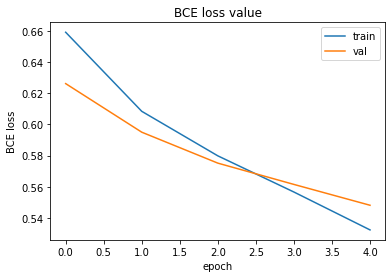

In [133]:
import matplotlib.pyplot as plt
lss = [los[1] for los in losses]
evs = [los[1] for los in losses_eval]
plt.plot(lss)
plt.plot(evs)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### fasttext

In [137]:
from gensim.models import FastText
fasttext = FastText(corpus['text'].tolist(), size=100, window=5, min_count=3)

In [139]:
import numpy as np

weights = np.zeros((len(word2id), 100))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = fasttext.wv[word]    
    except KeyError:
      count += 1
      # oov словам сопоставляем случайный вектор
      weights[i] = np.random.normal(0,0.1,100)

In [142]:
model = CNN(len(word2id), 100, weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() # Binary Cross Entropy

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

losses_ft = []
losses_eval_ft = []

for i in range(5):
    print(f'\nstarting Epoch {i}')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses_ft.append(epoch_loss)

    epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval_ft.append(epoch_loss_on_test)


starting Epoch 0
Training...
Val loss: 0.6666884928038626, Val f1: 0.5711579918861389
Val loss: 0.6296297987895225, Val f1: 0.6095152497291565
Val loss: 0.6120221414188347, Val f1: 0.6298003792762756
Val loss: 0.5980467279752095, Val f1: 0.6463456749916077
Val loss: 0.5891324546210159, Val f1: 0.65656977891922

Validating...
Val loss: 0.6107084155082703, Val f1: 0.8317893743515015
Val loss: 0.571240262190501, Val f1: 0.7689230442047119
Val loss: 0.5600466831870701, Val f1: 0.7475221753120422
Val loss: 0.5548958797608653, Val f1: 0.739115297794342
Val loss: 0.5528633365264306, Val f1: 0.7329834699630737

starting Epoch 1
Training...
Val loss: 0.5357935961448785, Val f1: 0.7541112303733826
Val loss: 0.525522429996462, Val f1: 0.7415659427642822
Val loss: 0.5173265054674432, Val f1: 0.7425519824028015
Val loss: 0.5120848066276974, Val f1: 0.7446827292442322
Val loss: 0.5091721078700567, Val f1: 0.7455108761787415

Validating...
Val loss: 0.5711358317307064, Val f1: 0.8523087501525879
Val

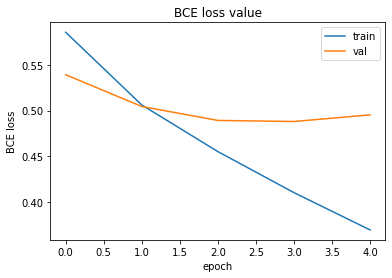

In [143]:
lss = [los[1] for los in losses_ft]
evs = [los[1] for los in losses_eval_ft]
plt.plot(lss)
plt.plot(evs)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

II. combine word2id + symbol2id

In [144]:
vocab = Counter()

for text in corpus['text']:
    for symbol in text:
        vocab.update(list(symbol))
print('всего уникальных символов:', len(vocab))

filtered_vocab = set()

for symbol in vocab:
    if vocab[symbol] > 5:
        filtered_vocab.add(symbol)
print('уникальных символов, втретившихся больше 5 раз:', len(filtered_vocab))

symbol2id = {'PAD':0}

for symbol in filtered_vocab:
    symbol2id[symbol] = len(symbol2id)

id2symbol = {i:symbol for symbol, i in symbol2id.items()}

всего уникальных символов: 127
уникальных символов, втретившихся больше 5 раз: 90


In [153]:
class CombineDataset(Dataset):

    def __init__(self, dataset, word2id, symbol2id, DEVICE):
        self.dataset = dataset['tokens'].values
        self.text = dataset['text'].values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = dataset['ttype'].values
        self.device = DEVICE

    def __len__(self): #это обязательный метод, он должен уметь считать длину датасета
        return self.length

    def __getitem__(self, index): #еще один обязательный метод. По индексу возвращает элемент выборки
        tokens = self.dataset[index] # токенизируем
        symbols = list(self.text)
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        symbol_ids = torch.LongTensor([self.symbol2id[sym] for sym in symbols if sym in self.symbol2id])
        y = [self.target[index]]
        return ids, symbol_ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      ids, symbol_ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      #мы хотим применять BCELoss, он будет брать на вход predicted размера batch_size x 1 (так как для каждого семпла модель будет отдавать одно число), target размера batch_size x 1
      padded_sym_ids = pad_sequence(symbol_ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device) # tuple ([1], [0], [1])  -> Tensor [[1.], [0.], [1.]] 
      return padded_ids, padded_sym_ids, y

In [149]:
class CombCNN(nn.Module):
    def __init__(self, words_vocab, sym_vocab, embedding_dim, weights=None):
        super().__init__()
        self.word_embedding = nn.Embedding(words_vocab, embedding_dim)
        self.sym_embedding = nn.Embedding(sym_vocab, embedding_dim)
        if weights is not None:
            self.word_embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.concated = nn.Conv1d(in_channels=180, out_channels=180, kernel_size=2, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=180, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, word, sym):
        #batch_size x seq_len
        sym_embedded = self.sym_embedding(sym)
        #batch_size x seq_len x embedding_dim
        sym_embedded =  sym_embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.relu(self.bigrams(sym_embedded))
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.relu(self.trigrams(sym_embedded))

        embedded = self.word_embedding(word)   # переводим последовательность индексов в последовательность эмбеддингов
        mean_emb = torch.mean(embedded, dim=1) # считаем средний эмбеддинг предложения
        
        pooling1 = feature_map_bigrams.max(2)[0] 
        pooling2 = feature_map_trigrams.max(2)[0]
        concat = torch.cat((pooling1, pooling2), 1)
        sym_logits = nn.Linear(concat, in_features=180, out_features=100)
 
        concat = torch.cat((sym_logits, mean_emb), 1)

        logits = self.out(self.hidden(concat))
        return logits

In [173]:
train_data, val_data = train_test_split(corpus[['tokens', 'text', 'ttype']], test_size=0.2, stratify=corpus['ttype'], random_state=42)

train_dataset = CombineDataset(train_data, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn=train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

val_dataset = CombineDataset(val_data, word2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn=train_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [174]:
def train(model, iterator, optimizer, criterion):
    print('Training...')
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах
    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    epoch_loss = 0
    epoch_metric = 0

    for i, (texts, symbols, ys) in enumerate(iterator): #итерируемся по батчам
        print(i)
        optimizer.zero_grad()  #обнуляем градиенты
        preds_proba = model(texts, symbols) #прогоняем данные через модель
        loss = criterion(preds_proba, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        batch_metric = f1(preds_proba.round().long(), ys.long(), ignore_index=0)
        epoch_metric += batch_metric

        if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке



def evaluate(model, iterator, criterion):
    print("\nValidating...")
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, symbols, ys) in enumerate(iterator):   
            predictions = model(texts, symbols)  # делаем предсказания на тесте
            loss = criterion(predictions, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(predictions.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric
            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
  
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем средний лосс по батчам

new_model = CombCNN(len(word2id), len(symbol2id), 100, weights)
optimizer = optim.Adam(new_model.parameters(), lr=0.001)
criterion = nn.BCELoss() # Binary Cross Entropy

# веса модели и значения лосса храним там же, где и все остальные тензоры
new_model = new_model.to(DEVICE)
criterion = criterion.to(DEVICE)

losses_ft = []
losses_eval_ft = []

for i in range(5):
    print(f'\nstarting Epoch {i}')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses_ft.append(epoch_loss)

    epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval_ft.append(epoch_loss_on_test)


starting Epoch 0
Training...
0


RuntimeError: ignored

запуталась(